<a href="https://colab.research.google.com/github/florivz/DDM-Project-WS24-25/blob/main/analysis_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/florivz/DDM-Project-WS24-25.git

Cloning into 'DDM-Project-WS24-25'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 71 (delta 35), reused 15 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (71/71), 38.74 MiB | 9.55 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [5]:
!pip install -q hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 70.9 MB/s eta 0:00:00


In [6]:
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import hdbscan
import cv2
from google.colab import userdata
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab.patches import cv2_imshow

# Loading the Data

In [7]:
pkl_path = 'DDM-Project-WS24-25/pkl/'

In [8]:
df_gdp = pd.read_pickle(pkl_path + "gdp.pickle")
df_pattern = pd.read_pickle(pkl_path + "naics_pattern.pickle")
df_occupation_1 = pd.read_pickle(pkl_path + "naics_occupation_part1.pickle")
df_occupation_2 = pd.read_pickle(pkl_path + "naics_occupation_part2.pickle")
df_occupation_3 = pd.read_pickle(pkl_path + "naics_occupation_part3.pickle")
df_county = pd.read_pickle(pkl_path + "county.pickle")
df_state = pd.read_pickle(pkl_path + 'state.pickle')

# Cleaning the data

In [9]:
def add_zeros(code):
    if len(code) == 3:
        return '00' + code
    elif len(code) == 4:
        return '0' + code
    elif len(code) == 1:
        return '0000' + code
    return code

In [10]:
df_pattern['FIPS'] = df_pattern['FIPS'].astype(str)
df_pattern['FIPS'] = df_pattern['FIPS'].apply(add_zeros)

In [11]:
df_occupation = pd.concat([df_occupation_1, df_occupation_2, df_occupation_3], ignore_index=True)
df_occupation.head()

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


# Industries

## Filtering & Aggregating the industries with most establishments per FIPS

In [12]:
df_pattern.head()

,State_GEOID,County_GEOID,FIPS,naics_2,naics,DESCRIPTION,emp_nf,emp,qp1_nf,qp1,...,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4
0,01,001,01001,11,1133,Logging,G,68,G,1213,...,N,N,N,N,N,N,N,N,N,N
1,01,001,01001,21,2123,Nonmetallic Mineral Mining and Quarrying,G,87,G,1224,...,N,N,N,N,N,N,N,N,N,N
2,01,001,01001,22,2211,"Electric Power Generation, Transmission and Di...",G,129,G,4418,...,N,N,N,N,N,N,N,N,N,N
4,01,001,01001,23,2362,Nonresidential Building Construction,H,69,H,685,...,N,N,N,N,N,N,N,N,N,N
5,01,001,01001,23,2371,Utility System Construction,H,65,H,1117,...,N,N,N,N,N,N,N,N,N,N


In [13]:
df_top_industries = df_pattern.groupby(['naics', 'DESCRIPTION']).agg({
    'emp': 'sum',
    'est': 'sum',
    'FIPS': 'nunique'
}).reset_index()

df_top_industries = df_top_industries.sort_values(by=['est', 'emp'], ascending=False)

df_top_industries.head(40)

,naics,DESCRIPTION,emp,est,FIPS
65,5617,Services to Buildings and Dwellings,2004960,220492,2530
13,2382,Building Equipment Contractors,2171001,193562,2756
67,8111,Automotive Repair and Maintenance,902870,164584,2725
14,2383,Building Finishing Contractors,811812,124074,2040
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924
12,2381,"Foundation, Structure, and Building Exterior C...",901696,101383,2313
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182
54,4413,"Automotive Parts, Accessories, and Tire Stores",532828,58112,2427
64,5613,Employment Services,7061425,57057,1306
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947


## Ranking the Industries

In [14]:
# make it on 4 digit level

tool_consumption_ranking_industries = {
    11: 2,   # Agriculture, Forestry, Fishing and Hunting
    21: 1,   # Mining
    22: 3,   # Utilities
    23: 1,   # Construction
    31: 1,   # Manufacturing
    32: 1,   # Manufacturing
    33: 1,   # Manufacturing
    42: 10,   # Wholesale Trade
    44: 10,   # Retail Trade
    45: 10,   # Retail Trade
    48: 3,   # Transportation and Warehousing
    49: 3,   # Transportation and Warehousing
    51: 10,   # Information
    52: 10,   # Finance and Insurance
    53: 8,   # Real Estate Rental and Leasing
    54: 4,  # Professional, Scientific, and Technical Services
    55: 10,   # Management of Companies and Enterprises
    56: 6,   # Administrative and Support and Waste Services
    61: 9,   # Educational Services
    62: 7,   # Health Care and Social Assistance
    71: 6,   # Arts, Entertainment, and Recreation
    72: 4,   # Accommodation and Food Services
    81: 8,   # Other Services (except Public Administration)
    92: 10    # Public Administration
}

def get_ranking(naics_code):
    naics_prefix = int(str(naics_code)[:2])
    return tool_consumption_ranking_industries.get(naics_prefix, None)

df_top_industries['tool_consumption_ranking'] = df_top_industries['naics'].apply(get_ranking).reset_index(drop=True)

df_top_industries.head(10)

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption_ranking
65,5617,Services to Buildings and Dwellings,2004960,220492,2530,1
13,2382,Building Equipment Contractors,2171001,193562,2756,1
67,8111,Automotive Repair and Maintenance,902870,164584,2725,1
14,2383,Building Finishing Contractors,811812,124074,2040,1
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924,1
12,2381,"Foundation, Structure, and Building Exterior C...",901696,101383,2313,10
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182,1
54,4413,"Automotive Parts, Accessories, and Tire Stores",532828,58112,2427,3
64,5613,Employment Services,7061425,57057,1306,1
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947,1


In [15]:
df_top_industries['tool_consumption_ranking'].isna().sum()

0

In [16]:
df_top_industries['rank_est'] = pd.qcut(
    df_top_industries['est'].rank(ascending=False),
    10,
    labels=range(1, 11)
)

df_top_industries['rank_emp'] = pd.qcut(
    df_top_industries['emp'].rank(ascending=False),
    10,
    labels=range(1, 11)
)

In [17]:
df_top_industries.head()

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption_ranking,rank_est,rank_emp
65,5617,Services to Buildings and Dwellings,2004960,220492,2530,1,1,1
13,2382,Building Equipment Contractors,2171001,193562,2756,1,1,1
67,8111,Automotive Repair and Maintenance,902870,164584,2725,1,1,1
14,2383,Building Finishing Contractors,811812,124074,2040,1,1,2
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924,1,1,1


In [18]:
weight_tool_consumption = 0.5
weight_emp = 0.3
weight_est = 0.2

df_top_industries['weighted_rank'] = (
    df_top_industries['tool_consumption_ranking'].astype(float) * weight_tool_consumption +
    df_top_industries['rank_emp'].astype(float) * weight_emp +
    df_top_industries['rank_est'].astype(float) * weight_est
)

df_top_industries.sort_values(by='weighted_rank').head(30)

,naics,DESCRIPTION,emp,est,FIPS,tool_consumption_ranking,rank_est,rank_emp,weighted_rank
65,5617,Services to Buildings and Dwellings,2004960,220492,2530,1,1,1,1.0
13,2382,Building Equipment Contractors,2171001,193562,2756,1,1,1,1.0
67,8111,Automotive Repair and Maintenance,902870,164584,2725,1,1,1,1.0
62,5413,"Architectural, Engineering, and Related Services",1579218,115269,1924,1,1,1,1.0
66,7139,Other Amusement and Recreation Industries,1092894,76488,2182,1,1,1,1.0
64,5613,Employment Services,7061425,57057,1306,1,2,1,1.2
14,2383,Building Finishing Contractors,811812,124074,2040,1,1,2,1.3
51,4238,"Machinery, Equipment, and Supplies Merchant Wh...",739134,54251,1947,1,2,2,1.5
50,4231,Motor Vehicle and Motor Vehicle Parts and Supp...,390199,21491,1030,1,2,3,1.8
21,3231,Printing and Related Support Activities,356146,21376,1116,1,2,3,1.8


In [19]:
top_5_naics = df_top_industries.sort_values(by='weighted_rank').head(5)['naics'].tolist()
top_5_naics

['5617', '2382', '8111', '5413', '7139']

# Filtering the FIPS with the highest amount of Top Industries


In [20]:
df_naics_feature = pd.DataFrame(df_pattern['FIPS'].unique(), columns=['FIPS'])

for naics_code in top_5_naics:
    est_values = df_pattern[df_pattern['naics'] == naics_code].groupby('FIPS')['est'].sum().reset_index()
    est_values.rename(columns={'est': f'est_{naics_code}'}, inplace=True)
    df_naics_feature = df_naics_feature.merge(est_values, on='FIPS', how='left')

df_naics_feature.fillna(0, inplace=True)

df_naics_feature.rename(columns={f'est_{naics}': f'est_{naics}' for naics in top_5_naics}, inplace=True)

df_naics_feature.head()

,FIPS,est_5617,est_2382,est_8111,est_5413,est_7139
0,01001,30.0,27.0,20.0,7.0,12.0
1,01003,229.0,187.0,93.0,94.0,69.0
2,01005,8.0,7.0,10.0,7.0,4.0
3,01007,5.0,8.0,7.0,0.0,0.0
4,01009,19.0,37.0,20.0,3.0,7.0


In [21]:
len(df_naics_feature)

3071

# Occupations

In [22]:
df_occupation.head()

,FIPS,State_GEOID,naics,NAICS_TITLE,emp_total_county_naics,OCC_CODE,OCC_TITLE,emp_occupation,state_name
0,12999,12,5613,Employment Services,1436559,49-9071,"Maintenance and Repair Workers, General",20639.514235,NaN
1,06999,6,5613,Employment Services,729335,49-9071,"Maintenance and Repair Workers, General",9414.167765,NaN
2,36999,36,5613,Employment Services,308333,49-9071,"Maintenance and Repair Workers, General",8332.850279,NaN
3,06037,6,8111,Automotive Repair and Maintenance,25081,49-3023,Automotive Service Technicians and Mechanics,5913.423292,California
4,48999,48,5613,Employment Services,340926,49-9071,"Maintenance and Repair Workers, General",5770.378034,NaN


In [23]:
tool_consumption_ranking_occ = {
    "00-0000": 10,  # All Occupations (broadest, general low need)
    "11-0000": 9,   # Management Occupations (low tool demand, focus on strategy)
    "13-0000": 8,   # Business and Financial Operations Occupations (tools like software)
    "15-0000": 3,   # Computer and Mathematical Occupations (high need for software tools)
    "17-0000": 3,   # Architecture and Engineering Occupations (high need for specialized tools)
    "19-0000": 6,   # Life, Physical, and Social Science Occupations (moderate tool need)
    "21-0000": 8,   # Community and Social Service Occupations (lower tool need)
    "23-0000": 7,   # Legal Occupations (moderate software/tool use)
    "25-0000": 9,   # Educational Instruction and Library Occupations (minimal tool demand)
    "27-0000": 6,   # Arts, Design, Entertainment, Sports, and Media Occupations (varied tool needs)
    "29-0000": 5,   # Healthcare Practitioners and Technical Occupations (specialized medical tools)
    "31-0000": 6,   # Healthcare Support Occupations (moderate tool use)
    "33-0000": 7,   # Protective Service Occupations (tools for safety and security)
    "35-0000": 10,  # Food Preparation and Serving Related Occupations (basic tool needs)
    "37-0000": 2,   # Building and Grounds Cleaning and Maintenance Occupations (simple tools)
    "39-0000": 9,   # Personal Care and Service Occupations (low specialized tool demand)
    "41-0000": 8,   # Sales and Related Occupations (low to moderate tool demand)
    "43-0000": 8,   # Office and Administrative Support Occupations (basic office tools)
    "45-0000": 3,   # Farming, Fishing, and Forestry Occupations (moderate traditional tool use)
    "47-0000": 1,   # Construction and Extraction Occupations (high demand for physical tools)
    "49-0000": 2,   # Installation, Maintenance, and Repair Occupations (tool-intensive)
    "51-0000": 1,   # Production Occupations (specialized machinery/tools)
    "53-0000": 3    # Transportation and Material Moving Occupations (moderate tool use)
}

In [24]:
def get_ranking_occ(occ_code):
    occ_prefix = occ_code[:2]
    return tool_consumption_ranking_occ.get(occ_prefix + "-0000", None)

df_occupation['rank_tool_consumption'] = df_occupation['OCC_CODE'].apply(get_ranking_occ)

df_occupation_agg = (
    df_occupation.groupby(['OCC_TITLE', 'OCC_CODE'])
    .agg(
        emp_occupation=(
        'emp_occupation', 'sum'
        ),
        rank_tool_consumption=(
        'rank_tool_consumption', 'first'
        ))
    .reset_index()
)

df_occupation_agg = df_occupation_agg.sort_values(by='rank_tool_consumption').reset_index(drop=True)

df_occupation_agg.head()

,OCC_TITLE,OCC_CODE,emp_occupation,rank_tool_consumption
0,"Model Makers, Metal and Plastic",51-4061,2337.422509,1
1,"Welding, Soldering, and Brazing Machine Setter...",51-4122,29207.279099,1
2,"Welders, Cutters, Solderers, and Brazers",51-4121,359511.557130,1
3,"Underground Mining Machine Operators, All Other",47-5049,1770.000000,1
4,"Loading and Moving Machine Operators, Undergro...",47-5044,3940.000000,1


In [25]:
df_occupation_agg['rank_emp'] = pd.qcut(
    df_occupation_agg['emp_occupation'].rank(ascending=False),
    10,
    labels=range(1, 11)
)

df_occupation_agg = df_occupation_agg.sort_values(by=['rank_tool_consumption', 'rank_emp']).reset_index(drop=True)

df_occupation_agg.head(5)

,OCC_TITLE,OCC_CODE,emp_occupation,rank_tool_consumption,rank_emp
0,"Welders, Cutters, Solderers, and Brazers",51-4121,359511.557130,1,1
1,Machinists,51-4041,287763.569434,1,1
2,"Cutting, Punching, and Press Machine Setters, ...",51-4031,165860.452744,1,1
3,Sheet Metal Workers,47-2211,117498.787647,1,2
4,"Molding, Coremaking, and Casting Machine Sette...",51-4072,161785.988126,1,2


In [26]:
top_occupations = df_occupation_agg.head(5)['OCC_CODE'].tolist()
top_occupations

['51-4121', '51-4041', '51-4031', '47-2211', '51-4072']

In [27]:
df_occ_features = pd.DataFrame(df_pattern['FIPS'].unique(), columns=['FIPS'])

for occ_code in top_occupations:
    occ_values = (
        df_occupation[df_occupation['OCC_CODE'] == occ_code]
        .groupby('FIPS')['emp_occupation']
        .sum()
        .reset_index()
    )
    occ_values.rename(columns={'emp_occupation': f'emp_occ_{occ_code}'}, inplace=True)
    df_occ_features = df_occ_features.merge(occ_values, on='FIPS', how='left')

df_occ_features.fillna(0, inplace=True)

df_occ_features.rename(columns={f'emp_occ_{occ}': f'emp_occ_{occ}' for occ in top_occupations}, inplace=True)

df_occ_features.head()

,FIPS,emp_occ_51-4121,emp_occ_51-4041,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4072
0,01001,7.703593,0.630670,0.099593,7.023607,0.044354
1,01003,193.563643,135.070777,73.931112,73.488520,48.057797
2,01005,7.442749,6.346958,9.013155,1.163592,10.888961
3,01007,8.764359,6.306702,0.663953,20.664265,0.110886
4,01009,37.770212,23.911795,9.544317,13.752811,1.064501


In [28]:
len(df_occ_features)

3071

# GDP Data

In [29]:
df_gdp.head()

,FIPS,GeoName,Region,TableName,LineCode,IndustryClassification,Description,Unit,2017,2018,2019,2020,2021,2022
0,0,United States,,CAGDP9,1,...,All industry total,Thousands of chained 2017 dollars,1.961210e+10,2.019390e+10,2.069209e+10,2.023407e+10,2.140769e+10,2.182204e+10
1,0,United States,,CAGDP9,2,...,Private industries,Thousands of chained 2017 dollars,1.715626e+10,1.771178e+10,1.819575e+10,1.776187e+10,1.890945e+10,1.928312e+10
2,0,United States,,CAGDP9,3,11,"Agriculture, forestry, fishing and hunting",Thousands of chained 2017 dollars,1.768400e+08,1.841050e+08,1.711490e+08,1.736590e+08,1.837420e+08,1.700580e+08
3,0,United States,,CAGDP9,6,21,"Mining, quarrying, and oil and gas extraction",Thousands of chained 2017 dollars,2.673020e+08,2.770130e+08,3.146040e+08,3.055880e+08,2.694780e+08,2.452900e+08
4,0,United States,,CAGDP9,10,22,Utilities,Thousands of chained 2017 dollars,3.137110e+08,3.092690e+08,3.129200e+08,3.323360e+08,3.166030e+08,3.183920e+08


In [30]:
df_gdp['FIPS'] = df_gdp['FIPS'].astype(str)

df_gdp = df_gdp[(df_gdp['FIPS'].astype(str).str.len() == 5) | (df_gdp['FIPS'].astype(str).str.len() == 4)]

df_gdp['FIPS'] = df_gdp['FIPS'].apply(add_zeros)

df_gdp_agg = df_gdp.groupby('FIPS').agg(
    gdp=('2022', 'sum')
).reset_index()

df_gdp_agg.head()

,FIPS,gdp
0,01000,1.091017e+09
1,01001,8.923713e+06
2,01003,4.162898e+07
3,01005,3.171057e+06
4,01007,1.752416e+06


In [31]:
len(df_gdp_agg)

3177

In [32]:
df_gdp['FIPS'].unique()

array(['01000', '01001', '01003', ..., '96000', '97000', '98000'],
      dtype=object)

# Final DataFrame

In [33]:
df_merged = pd.merge(df_occ_features, df_naics_feature, on='FIPS', how='inner')
df_merged.head()

,FIPS,emp_occ_51-4121,emp_occ_51-4041,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4072,est_5617,est_2382,est_8111,est_5413,est_7139
0,01001,7.703593,0.630670,0.099593,7.023607,0.044354,30.0,27.0,20.0,7.0,12.0
1,01003,193.563643,135.070777,73.931112,73.488520,48.057797,229.0,187.0,93.0,94.0,69.0
2,01005,7.442749,6.346958,9.013155,1.163592,10.888961,8.0,7.0,10.0,7.0,4.0
3,01007,8.764359,6.306702,0.663953,20.664265,0.110886,5.0,8.0,7.0,0.0,0.0
4,01009,37.770212,23.911795,9.544317,13.752811,1.064501,19.0,37.0,20.0,3.0,7.0


In [34]:
df_merged = pd.merge(df_merged, df_gdp_agg, on='FIPS', how='left')
df_merged.head()

,FIPS,emp_occ_51-4121,emp_occ_51-4041,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4072,est_5617,est_2382,est_8111,est_5413,est_7139,gdp
0,01001,7.703593,0.630670,0.099593,7.023607,0.044354,30.0,27.0,20.0,7.0,12.0,8923713.0
1,01003,193.563643,135.070777,73.931112,73.488520,48.057797,229.0,187.0,93.0,94.0,69.0,41628984.0
2,01005,7.442749,6.346958,9.013155,1.163592,10.888961,8.0,7.0,10.0,7.0,4.0,3171057.0
3,01007,8.764359,6.306702,0.663953,20.664265,0.110886,5.0,8.0,7.0,0.0,0.0,1752416.0
4,01009,37.770212,23.911795,9.544317,13.752811,1.064501,19.0,37.0,20.0,3.0,7.0,4165379.0


# Data Preprocessing

In [35]:
df_final = df_merged.copy()

In [36]:
df_final.head()

,FIPS,emp_occ_51-4121,emp_occ_51-4041,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4072,est_5617,est_2382,est_8111,est_5413,est_7139,gdp
0,01001,7.703593,0.630670,0.099593,7.023607,0.044354,30.0,27.0,20.0,7.0,12.0,8923713.0
1,01003,193.563643,135.070777,73.931112,73.488520,48.057797,229.0,187.0,93.0,94.0,69.0,41628984.0
2,01005,7.442749,6.346958,9.013155,1.163592,10.888961,8.0,7.0,10.0,7.0,4.0,3171057.0
3,01007,8.764359,6.306702,0.663953,20.664265,0.110886,5.0,8.0,7.0,0.0,0.0,1752416.0
4,01009,37.770212,23.911795,9.544317,13.752811,1.064501,19.0,37.0,20.0,3.0,7.0,4165379.0


In [37]:
# Impute Missing GDP with 0
df_final = df_final.dropna()

## Log 10 Scaled

In [38]:
X = df_final.drop(columns=['FIPS'])
X_log_scaled = np.log10(X + 1)
X_log_scaled = pd.DataFrame(X_log_scaled, columns=X.columns)

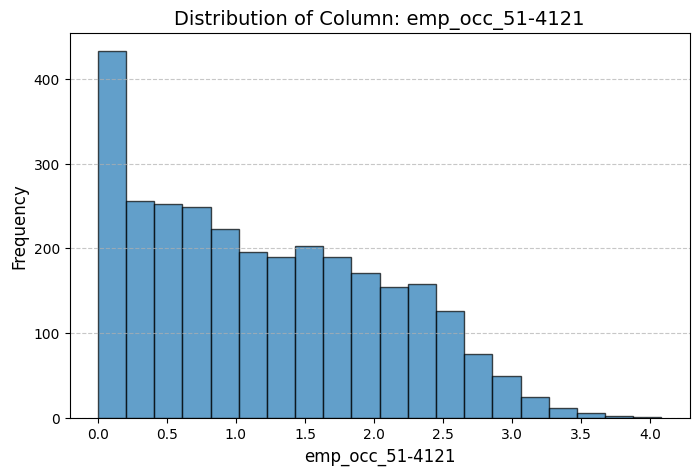

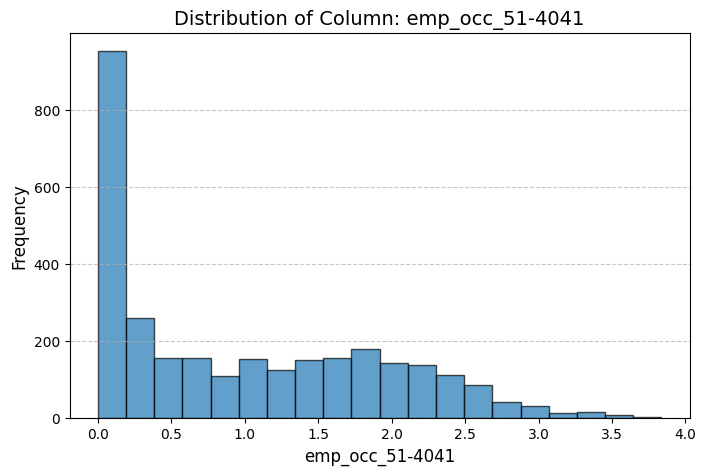

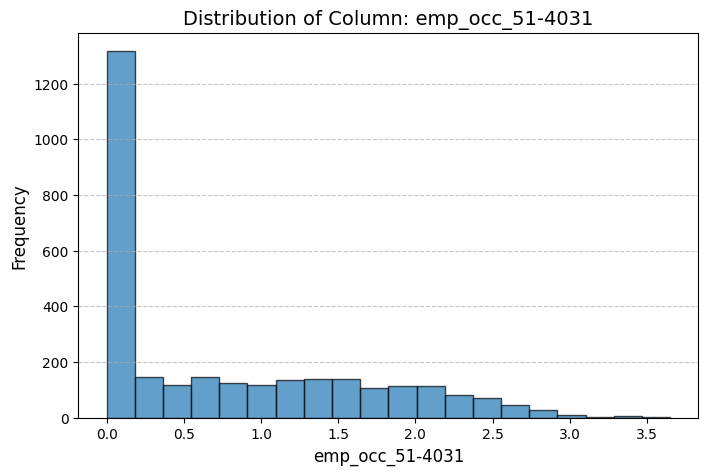

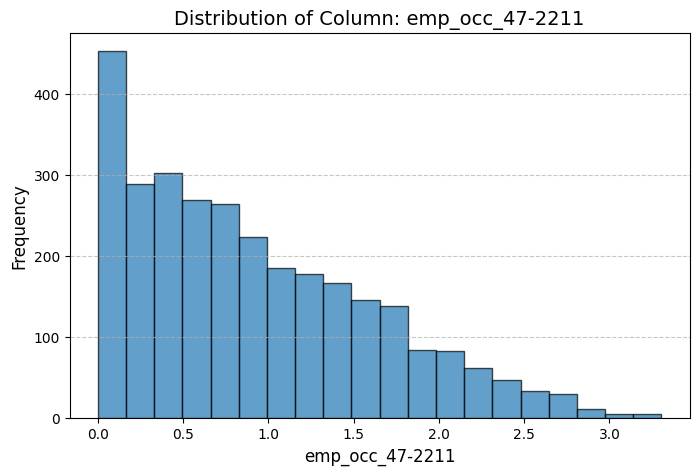

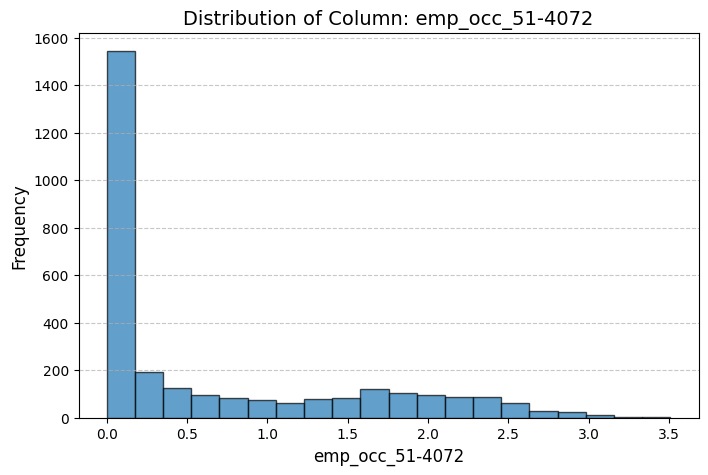

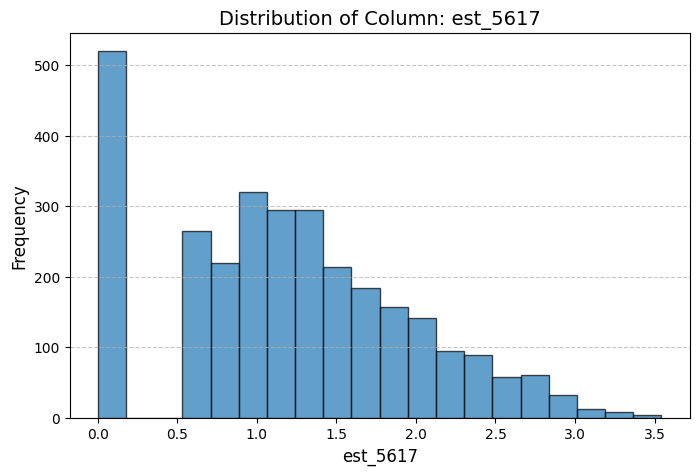

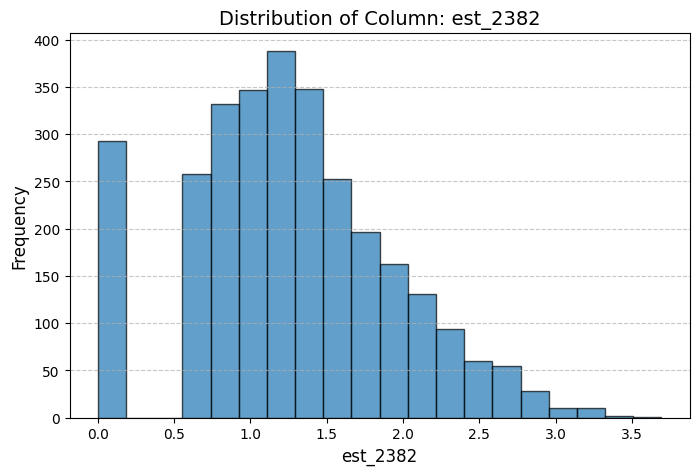

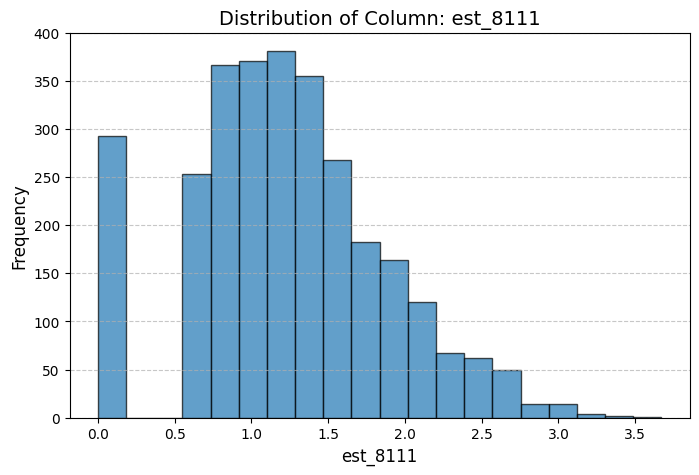

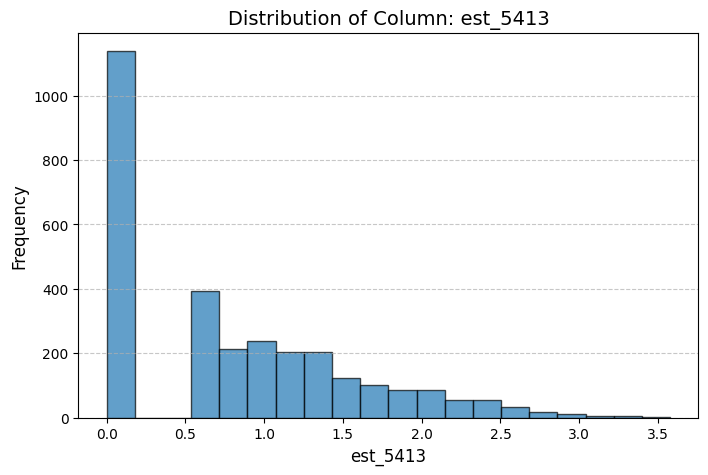

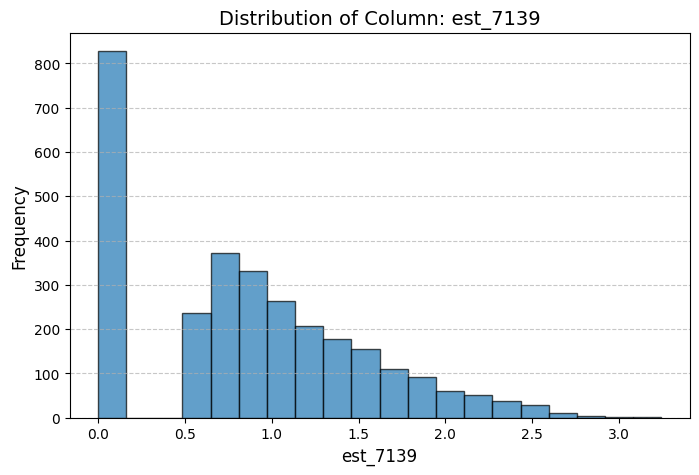

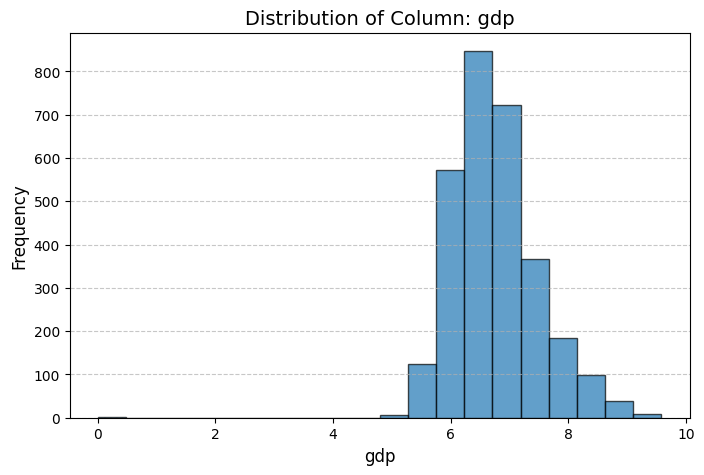

In [39]:
for column in X_log_scaled.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(X_log_scaled[column], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Column: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

## Standard Scaled

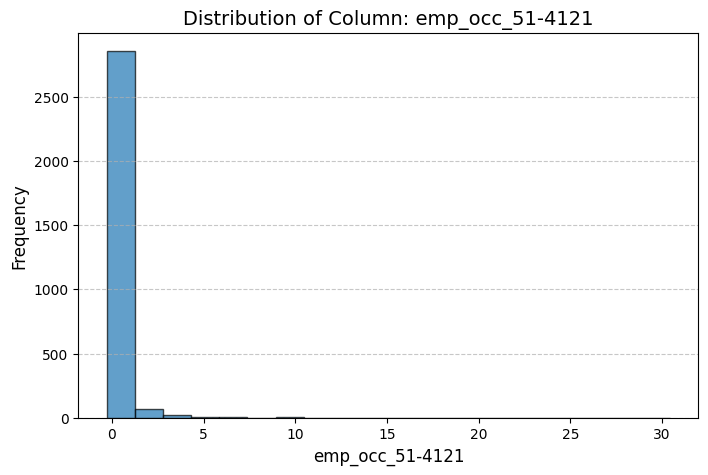

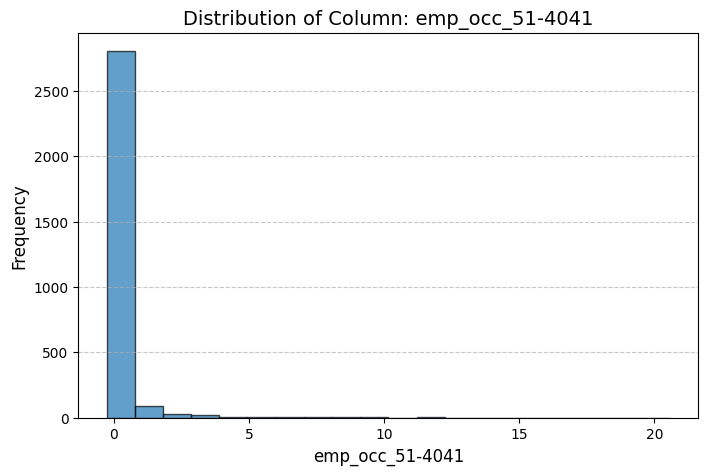

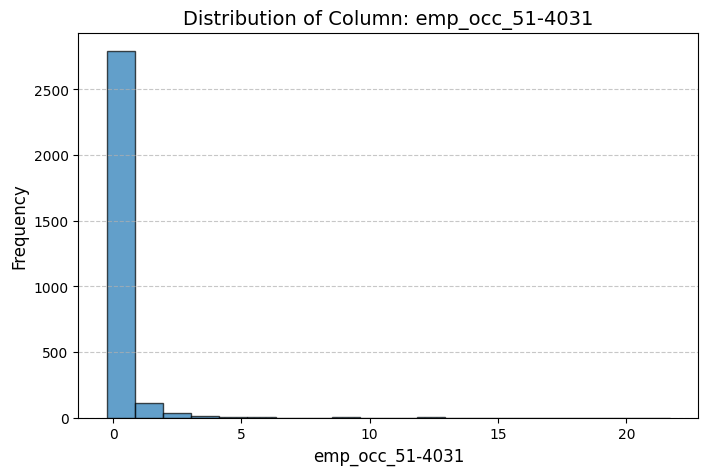

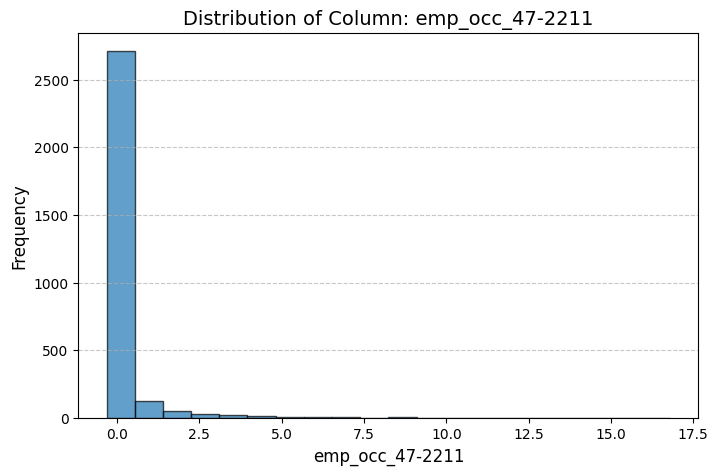

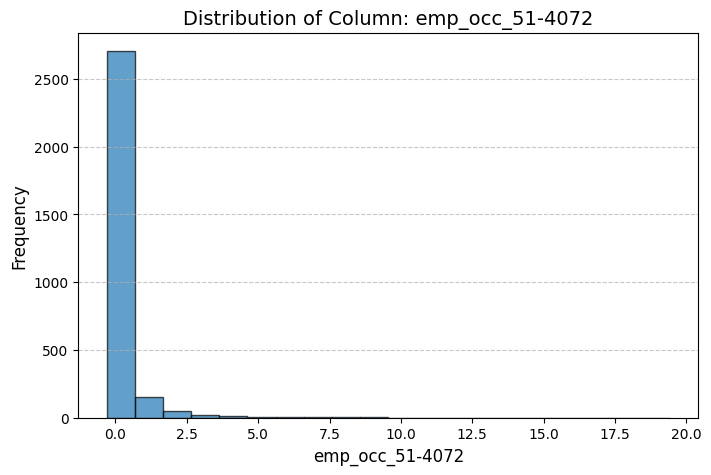

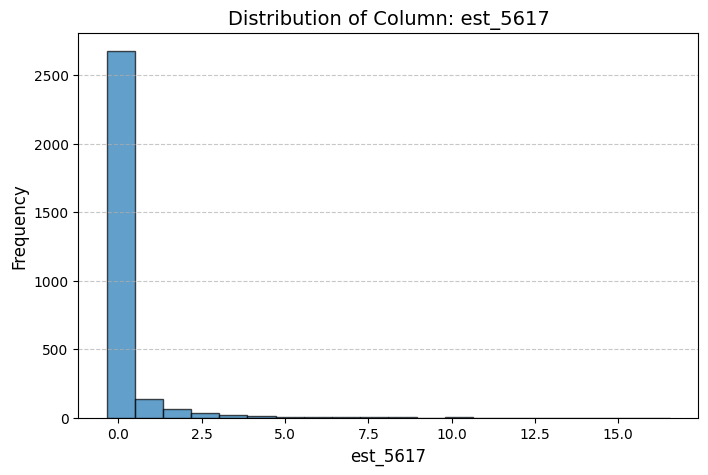

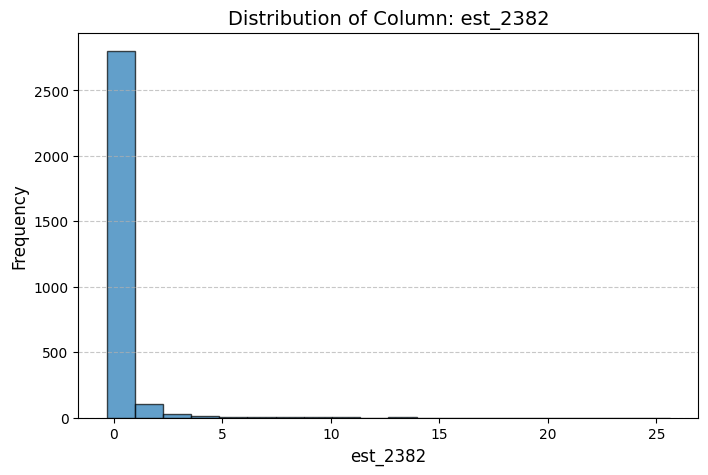

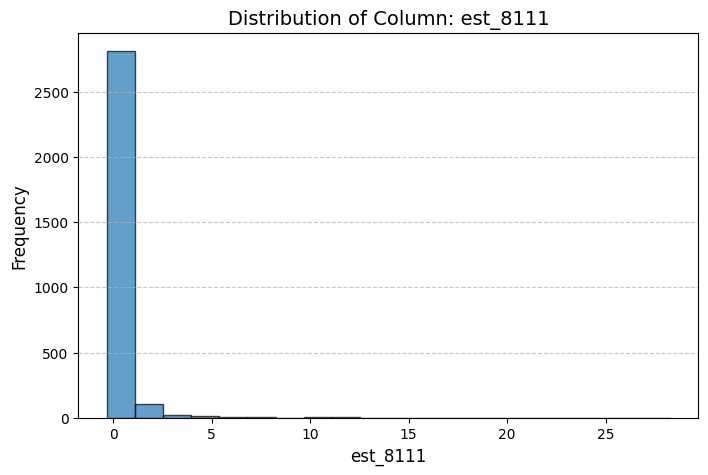

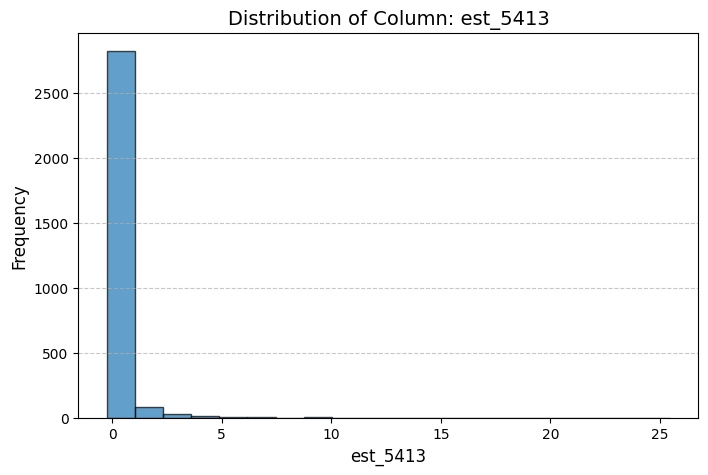

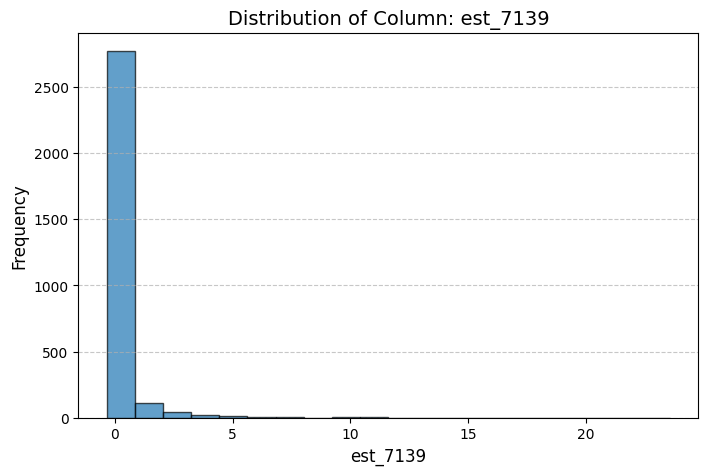

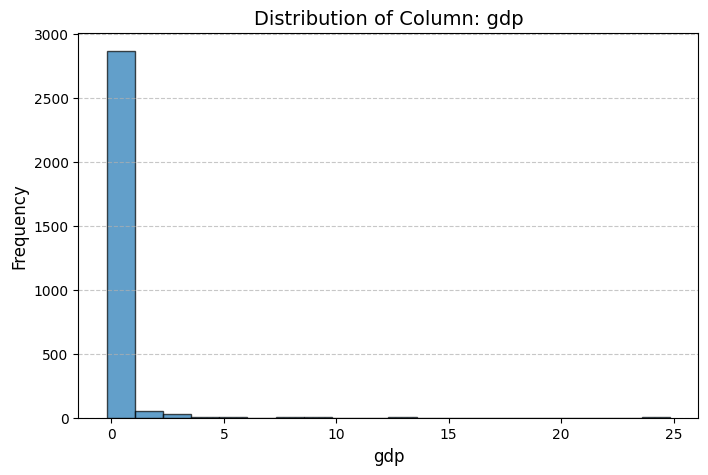

In [40]:
from sklearn.preprocessing import StandardScaler

X = df_final.drop(columns=['FIPS'])
scaler = StandardScaler()
X_standard_scaled = scaler.fit_transform(X)

X_standard_scaled = pd.DataFrame(X_standard_scaled, columns=X.columns)

for column in X_standard_scaled.columns:
    plt.figure(figsize=(8, 5))
    plt.hist(X_standard_scaled[column], bins=20, edgecolor='black', alpha=0.7)
    plt.title(f'Distribution of Column: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


# PCA

In [41]:
X_log_scaled.head()

,emp_occ_51-4121,emp_occ_51-4041,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4072,est_5617,est_2382,est_8111,est_5413,est_7139,gdp
0,0.939699,0.212366,0.041232,0.904370,0.018848,1.491362,1.447158,1.322219,0.903090,1.113943,6.950546
1,2.289062,2.133765,1.874662,1.872089,1.690708,2.361728,2.274158,1.973128,1.977724,1.845098,7.619396
2,0.926484,0.866108,1.000571,0.335175,1.075144,0.954243,0.903090,1.041393,0.903090,0.698970,6.501204
3,0.989644,0.863721,0.221141,1.335744,0.045669,0.778151,0.954243,0.903090,0.000000,0.000000,6.243637
4,1.588498,1.396405,1.023018,1.168875,0.314815,1.301030,1.579784,1.322219,0.602060,0.903090,6.619655


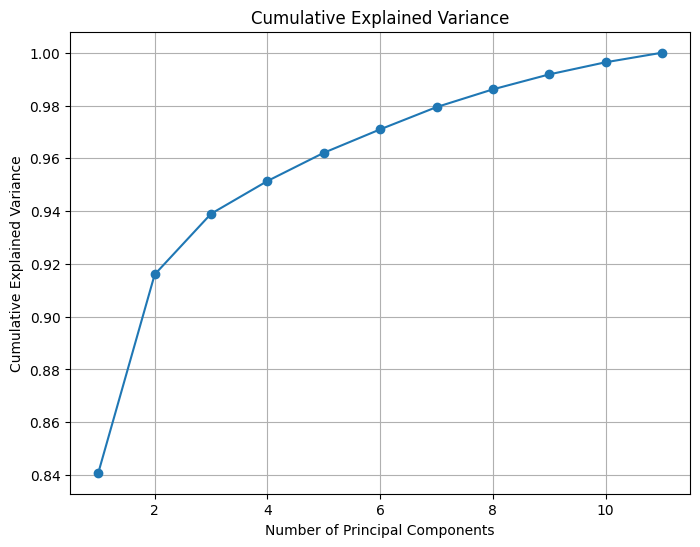

Number of components explaining 90% variance: 2


In [42]:
pca = PCA()
X_pca_log = pca.fit_transform(X_log_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f'Number of components explaining 90% variance: {n_components}')


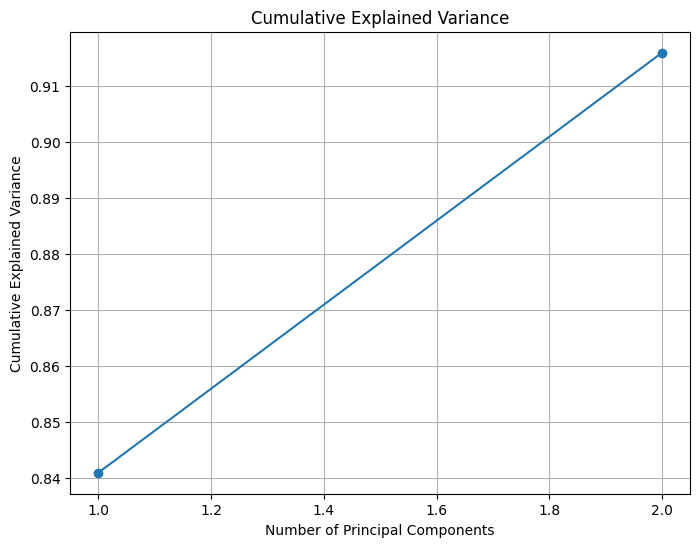

Number of components explaining 90% variance: 2


In [43]:
pca = PCA(n_components=n_components)
X_pca_standard_scaled = pca.fit_transform(X_log_scaled)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f'Number of components explaining 90% variance: {n_components}')


# Clustering

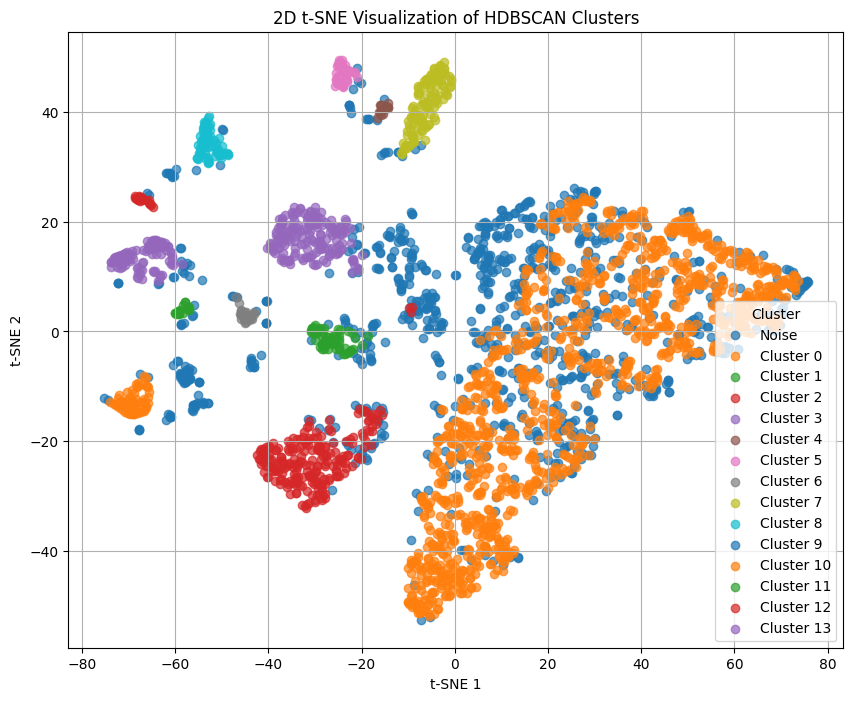

In [44]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=15)
clusters = hdbscan_clusterer.fit_predict(X_log_scaled)
df_final['cluster'] = clusters
X_tsne_2d = TSNE(n_components=2, random_state=1, perplexity=30).fit_transform(X_log_scaled)
plt.figure(figsize=(10, 8))
for c in np.unique(clusters):
    i = clusters == c
    l = 'Noise' if c == -1 else f'Cluster {c}'
    plt.scatter(X_tsne_2d[i, 0], X_tsne_2d[i, 1], label=l, alpha=0.7)
plt.title('2D t-SNE Visualization of HDBSCAN Clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [45]:
df_final['cluster'].unique()

array([ 0, -1, 13,  2,  3,  7,  4,  1,  9, 12, 10, 11,  6,  8,  5])

# Cluster Interpretation

In [46]:
df_final.head()

,FIPS,emp_occ_51-4121,emp_occ_51-4041,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4072,est_5617,est_2382,est_8111,est_5413,est_7139,gdp,cluster
0,01001,7.703593,0.630670,0.099593,7.023607,0.044354,30.0,27.0,20.0,7.0,12.0,8923713.0,0
1,01003,193.563643,135.070777,73.931112,73.488520,48.057797,229.0,187.0,93.0,94.0,69.0,41628984.0,0
2,01005,7.442749,6.346958,9.013155,1.163592,10.888961,8.0,7.0,10.0,7.0,4.0,3171057.0,-1
3,01007,8.764359,6.306702,0.663953,20.664265,0.110886,5.0,8.0,7.0,0.0,0.0,1752416.0,-1
4,01009,37.770212,23.911795,9.544317,13.752811,1.064501,19.0,37.0,20.0,3.0,7.0,4165379.0,0


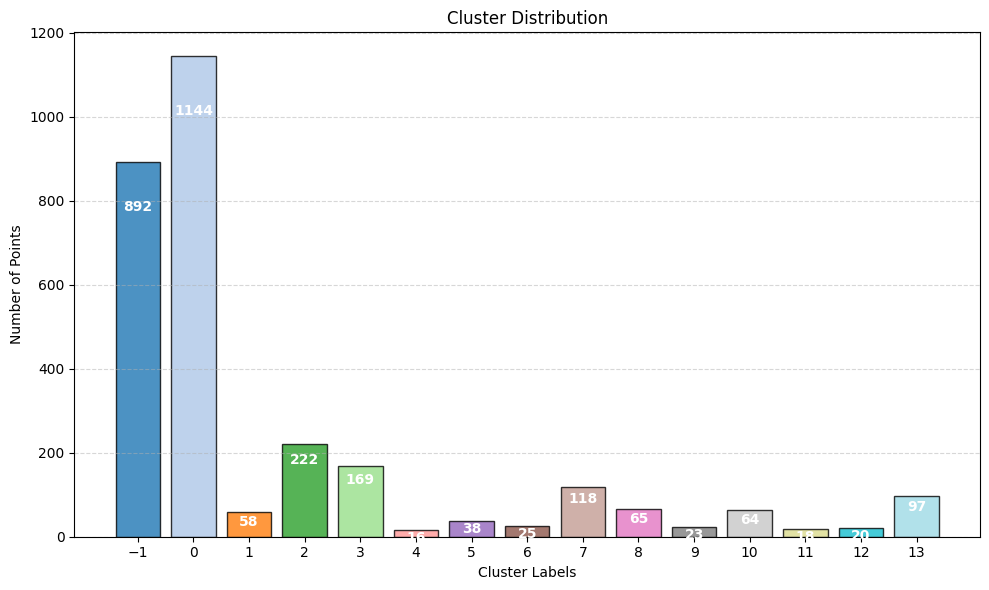

In [47]:
cluster_counts = df_final['cluster'].value_counts().sort_index()
unique_clusters = cluster_counts.index
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_clusters)))

plt.figure(figsize=(10, 6))

bars = plt.bar(
    unique_clusters,
    cluster_counts,
    color=colors,
    edgecolor='black',
    alpha=0.8
)

for bar, count in zip(bars, cluster_counts):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() - (bar.get_height() * 0.1),
        f'{count}',
        ha='center',
        va='top',
        fontsize=10,
        color='white',
        fontweight='bold'
    )

plt.title('Cluster Distribution')
plt.xlabel('Cluster Labels')
plt.ylabel('Number of Points')
plt.xticks(unique_clusters)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [48]:
df_final.head()

,FIPS,emp_occ_51-4121,emp_occ_51-4041,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4072,est_5617,est_2382,est_8111,est_5413,est_7139,gdp,cluster
0,01001,7.703593,0.630670,0.099593,7.023607,0.044354,30.0,27.0,20.0,7.0,12.0,8923713.0,0
1,01003,193.563643,135.070777,73.931112,73.488520,48.057797,229.0,187.0,93.0,94.0,69.0,41628984.0,0
2,01005,7.442749,6.346958,9.013155,1.163592,10.888961,8.0,7.0,10.0,7.0,4.0,3171057.0,-1
3,01007,8.764359,6.306702,0.663953,20.664265,0.110886,5.0,8.0,7.0,0.0,0.0,1752416.0,-1
4,01009,37.770212,23.911795,9.544317,13.752811,1.064501,19.0,37.0,20.0,3.0,7.0,4165379.0,0


In [49]:
cluster_summary = (
    df_final.groupby('cluster')
    .agg(
        count=('FIPS', 'size'),
        avg_est_5617=('est_5617', 'mean'),
        avg_est_2382=('est_2382', 'mean'),
        avg_est_8111=('est_8111', 'mean'),
        avg_est_5413=('est_5413', 'mean'),
        avg_est_7139=('est_7139', 'mean'),
        avg_emp_occ_51_4121=('emp_occ_51-4121', 'mean'),
        avg_emp_occ_51_4041=('emp_occ_51-4041', 'mean'),
        avg_emp_occ_51_4031=('emp_occ_51-4031', 'mean'),
        avg_emp_occ_47_2211=('emp_occ_47-2211', 'mean'),
        avg_emp_occ_51_4072=('emp_occ_51-4072', 'mean')
    )
    .reset_index()
)


cluster_summary.sort_values(by='count', ascending=False, inplace=True)

cluster_summary.head()

,cluster,count,avg_est_5617,avg_est_2382,avg_est_8111,avg_est_5413,avg_est_7139,avg_emp_occ_51_4121,avg_emp_occ_51_4041,avg_emp_occ_51_4031,avg_emp_occ_47_2211,avg_emp_occ_51_4072
1,0,1144,117.661713,99.116259,84.743881,54.421329,38.817308,161.694842,137.728240,82.677500,57.119995,82.821902
0,-1,892,89.153587,81.637892,68.026906,56.204036,33.434978,165.538477,122.467257,68.580936,51.179460,60.095474
3,2,222,8.112613,9.882883,9.806306,0.000000,4.954955,3.695357,1.615262,0.404637,2.356467,0.112499
4,3,169,5.852071,7.218935,7.059172,0.000000,0.000000,2.307264,0.596439,0.087865,1.648680,0.035010
8,7,118,0.000000,5.169492,5.254237,0.000000,0.000000,1.913671,0.320197,0.042372,0.953823,0.018407


In [50]:
df_result = df_final[(df_final['cluster'] == 0)].reset_index(drop=True)
df_result.head()

,FIPS,emp_occ_51-4121,emp_occ_51-4041,emp_occ_51-4031,emp_occ_47-2211,emp_occ_51-4072,est_5617,est_2382,est_8111,est_5413,est_7139,gdp,cluster
0,01001,7.703593,0.630670,0.099593,7.023607,0.044354,30.0,27.0,20.0,7.0,12.0,8923713.0,0
1,01003,193.563643,135.070777,73.931112,73.488520,48.057797,229.0,187.0,93.0,94.0,69.0,41628984.0,0
2,01009,37.770212,23.911795,9.544317,13.752811,1.064501,19.0,37.0,20.0,3.0,7.0,4165379.0,0
3,01015,423.488942,171.837509,180.711274,47.931562,461.505655,54.0,48.0,55.0,15.0,17.0,20744956.0,0
4,01021,32.031644,4.508621,5.842782,8.761985,0.266125,14.0,17.0,24.0,8.0,4.0,4891552.0,0


In [51]:
len(df_result)

1144

# Visualization

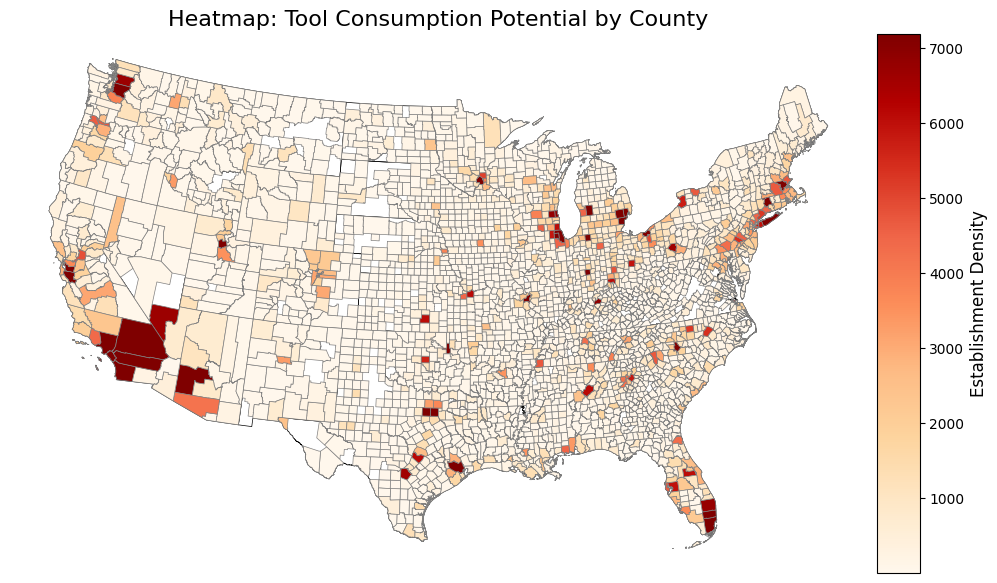

In [55]:
gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_final, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster['total_est'] = (
    gdf_cluster['est_5617'] +
    gdf_cluster['est_2382'] +
    gdf_cluster['est_8111'] +
    gdf_cluster['est_5413'] +
    gdf_cluster['est_7139'] +
    gdf_cluster['emp_occ_51-4121'] +
    gdf_cluster['emp_occ_51-4041'] +
    gdf_cluster['emp_occ_51-4031'] +
    gdf_cluster['emp_occ_47-2211'] +
    gdf_cluster['emp_occ_51-4072']
)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')

fig, ax = plt.subplots(figsize=(15, 7))

vmin = gdf_cluster['total_est'].quantile(0.01)
vmax = gdf_cluster['total_est'].quantile(0.99)

filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

heatmap = gdf_cluster.plot(
    column='total_est',
    cmap='OrRd',
    linewidth=0.5,
    ax=ax,
    edgecolor='0.5',
    legend=True,
    cax=cax,
    vmin=vmin,
    vmax=vmax
)

cax.set_ylabel('Establishment Density', fontsize=12)

ax.set_title('Heatmap: Tool Consumption Potential by County', fontsize=16)
ax.set_axis_off()

plt.show()


In [53]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf_county = gpd.GeoDataFrame(df_county, geometry='geometry')
gdf_states = gpd.GeoDataFrame(df_state, geometry='geometry')

gdf_county.crs = 'epsg:4269'
gdf_states.crs = 'epsg:4269'

non_contiguous_states = [
    'Alaska', 'Hawaii', 'Puerto Rico',
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa', 'United States Virgin Islands', 'Guam'
]

filtered_states = gdf_states[~gdf_states['NAME'].isin(non_contiguous_states)]
filtered_statefps = filtered_states['STATEFP'].unique()
filtered_county = gdf_county[gdf_county['STATEFP'].isin(filtered_statefps)]

gdf_cluster = filtered_county.merge(df_final_scaled, left_on='GEOID', right_on='FIPS', how='inner')

gdf_cluster['total_est'] = (
    gdf_cluster['est_5617'] +
    gdf_cluster['est_2382'] +
    gdf_cluster['est_8111'] +
    gdf_cluster['est_5413'] +
    gdf_cluster['est_7139']
)

gdf_cluster = gdf_cluster.to_crs('epsg:5070')
filtered_states = filtered_states.to_crs('epsg:5070')
filtered_county = filtered_county.to_crs('epsg:5070')

gdf_cluster['centroid'] = gdf_cluster.geometry.centroid

fig, ax = plt.subplots(figsize=(15, 7))

filtered_states.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5)

gdf_cluster.set_geometry('centroid').plot(
    ax=ax,
    color='red',
    markersize=gdf_cluster['total_est'] / gdf_cluster['total_est'].max() * 100,
    alpha=0.7
)

ax.set_title('Counties with High Potential Tool Consumption', fontsize=16)
ax.set_axis_off()

plt.show()


NameError: name 'df_final_scaled' is not defined

In [ ]:
image_path = '/content/DDM-Project-WS24-25/usa_economic_key_regions.png'
image = cv2.imread(image_path)

cv2_imshow(image)
cv2.waitKey(0)
cv2.destroyAllWindows()

- The Manufacturing Belt around Chicago and Detroit is the largest and oldest industrial region in the U.S., recently impacted by significant structural change.

- The East Coast metropolitan area, from Boston through New York to Washington, is a leading hub for high-tech industries, diverse manufacturing, and major service centers.

- The Portland/Seattle area is known for strong high-tech and aerospace industries, alongside timber processing and paper manufacturing.

- Economic centers in the West include San Francisco and the Silicon Valley (electronics and computer industries) as well as Los Angeles/San Diego (high-tech, heavy and light industries, and services). Together with mining, industrial, high-tech, and service hubs in Phoenix, Dallas, Houston/New Orleans, Atlanta, and Florida, these regions form the Sunbelt, the U.S. economy's growth area.